# 人工神經網路的簡單通用框架

進一步再分離加權與啟動函式。

In [53]:
import numpy as np

##  二元交叉熵損失函數與梯度

In [54]:
def sigmoid(x):
    # Sigmoid 函數，常用在二元分類，將輸入值壓到 0~1 之間
    return 1 / (1 + np.exp(-x))

def binary_cross_entropy(f, y, epsilon=1e-8):
    # 二元交叉熵損失函數
    # f: 模型預測值 (機率)
    # y: 真實標籤 (0 或 1)
    # epsilon: 避免 log(0) 用的小常數

    # 原本可能是想逐筆算 loss（被註解掉）
    # np.sum(y*np.log(f+epsilon)+ (1-y)*np.log(1-f+epsilon), axis=1)

    m = len(y)  # 資料筆數
    # 計算整體平均 loss
    return - (1./m) * np.sum(
        np.multiply(y, np.log(f + epsilon)) +
        np.multiply((1 - y), np.log(1 - f + epsilon))
    )

def binary_cross_entropy_grad(out, y, sigmoid_out=True, epsilon=1e-8):
    # 計算 binary cross entropy 對輸出值的梯度
    # out: 模型輸出
    # y: 真實標籤
    # sigmoid_out: 表示 out 是否已經過 sigmoid

    if sigmoid_out:
        f = out  # 如果已經是 sigmoid 輸出，直接使用
        grad = ((f - y) / (f * (1 - f) + epsilon)) / (len(y))
        # f = np.clip(f, eps, 1 - eps) # 建議寫法
        # grad = ((f - y) / (f * (1 - f))) / (len(y))
    else:
        f = sigmoid(out)  # 如果 out 是 z，先做 sigmoid
        grad = (f - y) / (len(y))

def binary_cross_entropy_loss_grad(out, y, sigmoid_out=True, epsilon=1e-8):
    # 同時計算 loss 與 gradient
    # 常用在訓練時一次回傳兩個結果

    if sigmoid_out:
        f = out  # 已經是 sigmoid 結果
        grad = ((f - y) / (f * (1 - f) + epsilon)) / (len(y))
        # f = np.clip(f, eps, 1 - eps) # 建議寫法
        # grad = ((f - y) / (f * (1 - f))) / (len(y))
    else:
        f = sigmoid(out)  # out 是尚未經過 sigmoid 的值
        grad = (f - y) / (len(y))

    # 計算 binary cross entropy loss
    loss = binary_cross_entropy(f, y, epsilon)

    return loss, grad

## softmax交叉熵損失函數與梯度

In [55]:
def softmax(Z):
    # 對輸入的 Z 做 softmax，先減掉最大值避免數值爆掉
    A = np.exp(Z - np.max(Z, axis=-1, keepdims=True))
    # 將指數結果做正規化，讓每一列加起來等於 1
    return A / np.sum(A, axis=-1, keepdims=True)

def softmax_cross_entropy(Z, y, onehot=False):
    # 樣本的總數（有幾筆資料）
    m = len(Z)

    # 先把模型輸出 Z 丟進 softmax，算出每一類的機率
    F = softmax(Z)

    if onehot:
        # 如果 y 是 one-hot 編碼
        # 直接用 cross entropy 的公式算 loss
        loss = -np.sum(y * np.log(F)) / m
    else:
        # 如果 y 是類別的 index（例如 0、1、2）
        # 把 y 攤平成一維（但這行實際上不會影響後面）
        y.flatten()

        # 取出每筆資料「正確類別」對應的機率，再取 log
        log_Fy = -np.log(F[range(m), y])

        # 把所有樣本的 loss 加起來，再取平均
        loss = np.sum(log_Fy) / m

    return loss

def cross_entropy_grad(Z, Y, onehot=False, softmax_out=False):
    # 判斷輸入的 Z 是不是已經是 softmax 的輸出
    if softmax_out:
        F = Z
    else:
        # 如果不是，就先做一次 softmax
        F = softmax(Z)

    if onehot:
        # 如果 Y 是 one-hot 編碼，直接用 F - Y
        grad = (F - Y) / len(Z)
    else:
        # 如果 Y 是類別索引（例如 [0, 2, 1]）
        m = len(Y)          # 樣本數
        grad = F.copy()       # 複製一份避免動到原本的 F
        # 對正確類別的位置減 1
        grad[np.arange(m), Y] -= 1
        # 對 batch size 做平均
        grad /= m

        # 以下是另一種寫法，這裡先註解起來
        # I_i = np.zeros_like(Z)
        # I_i[np.arange(len(Z)),Y] = 1
        # return (F - I_i) /len(Z)  #Z.shape[0]

    # 回傳對 Z 的梯度
    return grad

# def cross_entropy_grad_loss(F, y, softmax_out=False, onehot=False):
#     # 判斷輸入的 F 是否已經經過 Softmax 處理
#     if softmax_out:
#         # 如果已經是機率分布了，直接丟進去算 Loss
#         loss = softmax_cross_entropy(F, y, onehot)
#         # 註解掉的這行可能是想區分一般的 Cross Entropy 與 Softmax 版
#         # loss = cross_entropy_loss(F, y, onehot)
#     else:
#         # 如果 F 還是 Logits（原始輸出），則執行含 Softmax 的 Cross Entropy 計算
#         loss = softmax_cross_entropy(F, y, onehot)

#     # 計算梯度（Grad），同樣會根據 softmax_out 決定內部是否要補做 Softmax
#     grad = cross_entropy_grad(F, y, onehot, softmax_out)

#     # 同時回傳損失值與梯度，方便後向傳播使用
#     return loss, grad

def cross_entropy_grad_loss(Z, y, softmax_out=False, onehot=False):
    """
    優化後的函式：共用 Softmax 運算結果，同時回傳 Loss 與 Gradient。
    """
    # 1. 決定機率分布 F (Softmax 的結果)
    if softmax_out:
        # 如果已經是 Softmax 輸出，直接共用
        F = Z
    else:
        # 如果是 Logits，算一次 Softmax 就好，後面大家都用這份 F
        F = softmax(Z)

    # 2. 計算 Loss
    # 注意：這裡我們傳入已經算好的 F，並告訴後面的函式 softmax_out=True
    # (假設你原有的 softmax_cross_entropy 有支援這個判斷，或是我們直接在這裡算)
    m = len(y)
    if onehot:
        loss = -np.sum(y * np.log(F + 1e-12)) / m
    else:
        # 這裡示範直接計算，減少函式呼叫的開銷
        loss = -np.sum(np.log(F[np.arange(m), y] + 1e-12)) / m

    # 3. 計算梯度 (Gradient)
    # 直接利用剛剛算好的 F 進行計算，效能最優
    grad = F.copy()
    if onehot:
        grad = (grad - y) / m
    else:
        grad[np.arange(m), y] -= 1
        grad /= m

    return loss, grad

## 平均平方誤差損失函數與梯度

In [56]:
def mse_loss(F, Y, divid_2 = False):
    m = F.shape[0]
    loss =  np.sum((F - Y) ** 2)/m
    # loss = np.mean((F - Y)**2, axis=0).sum()
    if divid_2:
        loss /= 2
    return loss

def mse_loss_grad(f, y):
    m = len(f)
    # 計算資料筆數（樣本數）

    loss = (1./m) * np.sum((f - y) ** 2)
    # 計算 MSE（均方誤差），用來衡量預測值跟實際值的差距

    grad = (2./m) * (f - y)
    # 計算 MSE 對預測值 f 的梯度，常用在梯度下降

    return loss, grad
    # 回傳 loss 值以及對應的梯度

## 其他函數

In [57]:
def dRelu(x):
    # ReLU 的微分：x > 0 回傳 1，否則回傳 0
    return 1 * (x > 0)

def max_abs(s):
    # 計算一組矩陣或向量中，所有元素的最大絕對值
    max_value = 0
    for x in s:
        max_value_ = np.max(np.abs(x))  # 取單一矩陣的最大絕對值
        if(max_value_ > max_value):
            max_value = max_value_
    return max_value

# 產生一個非線性可分（Non-linearly separable）的「旋渦狀」資料集
def gen_spiral_dataset(N=100, D=2, K=3):
    # 初始化特徵矩陣 X，形狀為 (樣本總數, 維度)，這裡預設產生 300 筆 2 維資料
    X = np.zeros((N*K, D))  # 建立資料矩陣，每一列代表一筆資料

    # 初始化標籤陣列 y，記錄每筆資料屬於哪一個類別（0, 1, 2）
    y = np.zeros(N*K, dtype='uint8')  # 建立標籤陣列，用來存每筆資料的類別

    for j in range(K):  # 依序產生每一個類別 (Class) 的資料
        # 計算目前類別在矩陣中對應的索引範圍 (Index range)
        ix = range(N*j, N*(j+1))

        # 產生半徑 r，從 0 到 1 均勻分布，代表點從原點往外擴散
        r = np.linspace(0.0, 1, N)  # 半徑，從中心往外均勻增加

        # 產生角度 t，隨類別不同有不同的起始角度，並加入高斯雜訊 (Noise) 讓資料不會太死板
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2  # 角度，加上一點雜訊讓資料比較分散

        # 利用極座標轉直角座標 (r*sin(t), r*cos(t))，並用 np.c_ 進行欄位合併
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]  # 轉成平面座標，形成螺旋狀

        # 填入對應的類別編號
        y[ix] = j  # 設定對應的類別標籤

    return X, y  # 回傳產生的特徵矩陣 X 與目標標籤 y

## 神經網路層子類別

In [58]:
class Layer:
    def __init__(self):
        self.params = None
        pass
    def forward(self, x):       
        raise NotImplementedError
    def backward(self, x, grad):        
        raise NotImplementedError
    def reg_grad(self, reg):
        pass
    def reg_loss(self, reg):
        return 0.  
    
#---------- 加權總和計算 (全連接層) ------------    
class Dense(Layer): 
    # 計算公式：Z = XW + b
    def __init__(self, input_dim, out_dim, init_method=('random', 0.01)):  
        super().__init__()
        random_method_name, random_value = init_method      
        
        # 根據不同的初始化方法設定權重 (W) 與偏置項 (b)
        if random_method_name == "random":
            # 一般隨機初始化
            self.W = np.random.randn(input_dim, out_dim) * random_value
            self.b = np.random.randn(1, out_dim) * random_value  
        elif random_method_name == "he":
            # He 初始化：適用於 ReLU 激活函數，保持變異數一致
            self.W = np.random.randn(input_dim, out_dim) * np.sqrt(2 / input_dim)
            self.b = np.zeros((1, out_dim))
        elif random_method_name == "xavier":
            # Xavier 初始化 (Glorot)：適用於 Sigmoid/Tanh，平衡層與層之間的訊號
            self.W = np.random.randn(input_dim, out_dim) * np.sqrt(1 / input_dim)
            self.b = np.random.randn(1, out_dim) * random_value  
        elif random_method_name == "zeros":
            # 全零初始化（通常不建議對 W 使用，會導致神經元對稱）
            self.W = np.zeros((input_dim, out_dim))
            self.b = np.zeros((1, out_dim))   
        else:            
            self.W = np.random.randn(input_dim, out_dim) * random_value
            self.b = np.zeros((1, out_dim))  
            
        self.params = [self.W, self.b]
        # 儲存對應參數的梯度
        self.grads = [np.zeros_like(self.W), np.zeros_like(self.b)]
        
    def forward(self, x): 
        self.x = x        
        # 攤平 (Flatten)：將多維度輸入（如影像卷積後的結果）轉換為 2D 矩陣 (Batch_size, Features)
        x1 = x.reshape(x.shape[0], np.prod(x.shape[1:])) 
        # 矩陣相乘並加上偏置項
        Z = np.matmul(x1, self.W) + self.b        
        return Z
    
    def backward(self, dZ):
        # 反向傳播 (Backpropagation)
        x = self.x
        # 同樣進行攤平操作以計算梯度
        x1 = x.reshape(x.shape[0], np.prod(x.shape[1:]))
        
        # 計算參數梯度：dW = X.T * dZ, db = sum(dZ)
        dW = np.dot(x1.T, dZ)
        db = np.sum(dZ, axis=0, keepdims=True)          
        
        # 計算對輸入 x 的梯度 (dx)，用於傳回前一層
        dx = np.dot(dZ, np.transpose(self.W)) 
        # 將 dx 還原成與原始輸入相同的形狀 (Reverse Flatten)
        dx = dx.reshape(x.shape)    
        
        # 梯度累加，以便在 Optimizer 更新前儲存多個 Batch 的結果
        self.grads[0] += dW
        self.grads[1] += db
       
        return dx
    
    #-------- 添加正規化項 (L2 Regularization) 的梯度 -----
    def reg_grad(self, reg):
        # L2 正規化梯度：2 * reg * W
        self.grads[0] += 2 * reg * self.W
        
    def reg_loss(self, reg):
        # L2 正規化損失值：reg * sum(W^2)
        return reg * np.sum(self.W**2)
    
    def reg_loss_grad(self, reg):
        # 同時回傳損失並累加梯度
        self.grads[0] += 2 * reg * self.W
        return reg * np.sum(self.W**2)

## 測試：人工神經網路的向前函式

In [59]:
# 設定隨機種子，確保每次產生的隨機數結果都一樣，方便除錯與重現結果
np.random.seed(1)

# 產生一個隨機矩陣
# 形狀為 (3, 3, 4, 4)，代表 3 筆資料，每筆資料有 3 個通道，每個通道是 4x4 的圖像
x = np.random.randn(3, 3, 4, 4) # 3 個樣本，每個樣本有 48 維特徵

# 建立一個全連接層 (Dense Layer)
# 輸入維度為 48，輸出維度為 10，啟用函數設定為 'none'
dense = Dense(3 * 4 * 4, 10, ('no', 0.01))

# 將輸入資料丟進 Dense 層做前向傳播
o = dense.forward(x)

# 輸出結果的形狀
print(o.shape)

# 輸出實際計算結果
print(o)

(3, 10)
[[-0.03953509 -0.00214997  0.00743433 -0.16926214 -0.05162853  0.06734225
  -0.00221485 -0.11710758 -0.07046456  0.02609659]
 [ 0.00848392  0.08259757 -0.09858177  0.0374092  -0.08303008  0.04151241
  -0.01407859 -0.02415486  0.04236149  0.0648261 ]
 [-0.13877363 -0.04122276 -0.00984716 -0.03461381  0.11513754  0.1043094
   0.00170353 -0.00449278 -0.0057236  -0.01403174]]


## 通用數值梯度函式

In [60]:
def numerical_gradient_from_df(f, p, df, h=1e-5):
  # 建立一個與 p 形狀相同、內容全為 0 的陣列，用來存每個參數的梯度
  grad = np.zeros_like(p)

  # 使用 nditer 逐一走訪 p 中的每一個元素（支援多維陣列）
  it = np.nditer(p, flags=['multi_index'], op_flags=['readwrite'])

  # 只要 iterator 還沒跑完就持續計算
  while not it.finished:
    # 取得目前走訪到的索引位置
    idx = it.multi_index

    # 先把原本的參數值存起來
    oldval = p[idx]

    # 將該參數往正方向微調一點
    p[idx] = oldval + h
    pos = f()       # 在參數被改動後重新呼叫 f()，取得正方向的輸出結果

    # 將該參數往負方向微調一點
    p[idx] = oldval - h
    neg = f()       # 在參數被改動後重新呼叫 f()，取得負方向的輸出結果

    # 將參數值還原成原本的狀態，避免影響下一次計算
    p[idx] = oldval

    # 使用中央差分法計算梯度，並與上游傳下來的 df 做加權
    grad[idx] = np.sum((pos - neg) * df) / (2 * h)

    # 另一種寫法（使用內積），目前被註解掉
    # grad[idx] = np.dot((pos - neg), df) / (2 * h)

    # 移動到下一個參數位置
    it.iternext()

  # 回傳整個參數 p 的數值梯度
  return grad

# 通用數值梯度函式
def numerical_gradient(f, params, eps=1e-6):
    numerical_grads = []  # 用來存每一個參數對應的梯度

    for x in params:
        # x 可能是多維陣列，這裡會針對 x 裡面的每一個元素計算數值梯度
        grad = np.zeros(x.shape)  # 建立一個跟 x 形狀一樣的陣列來存梯度

        # 使用 nditer 逐一走訪 x 裡面的每個元素
        it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])

        while not it.finished:
            idx = it.multi_index   # 目前元素的索引位置

            old_value = x[idx]     # 先把原本的值存起來

            x[idx] = old_value + eps  # 對目前的值加上一個很小的 eps
            fx = f()                  # 計算 f(x + eps) 的結果

            x[idx] = old_value - eps  # 對目前的值減去一個很小的 eps
            fx_ = f()                 # 計算 f(x - eps) 的結果

            # 使用中央差分法計算數值梯度
            grad[idx] = (fx - fx_) / (2 * eps)

            x[idx] = old_value        # 記得把參數值還原，避免影響後續計算
            it.iternext()             # 移動到下一個元素

        numerical_grads.append(grad)  # 將目前參數的梯度存起來

    return numerical_grads            # 回傳所有參數的梯度

# def f():
#     return compute_loss_reg(forward_propagation, softmax_cross_entropy_reg, X, y, parameters)

In [61]:
# 隨機產生一個形狀為 (3, 10) 的梯度輸出（do），模擬後層回傳的誤差
do = np.random.randn(3, 10)

# 呼叫 dense 層的 backward 函式，計算輸入 x 的梯度（dx）
dx = dense.backward(do)

# 透過數值微分（numerical gradient）計算 x 的梯度，作為基準值 (dx_num)
dx_num = numerical_gradient_from_df(lambda :dense.forward(x), x, do)

# 定義一個計算相對誤差的匿名函式，用來衡量手寫梯度與數值梯度的差異
# 這裡使用 np.maximum(1e-8, ...) 是為了避免除以零的情況
diff_error = lambda x, y: np.max(np.abs(x - y)/(np.maximum(1e-8, np.abs(x) + np.abs(y) )) )

# 印出輸入 x 的梯度誤差，理想情況下這個值應該要非常小（例如小於 1e-7）
print(diff_error(dx, dx_num))

# 針對權重（Weights，即 dense.params[0]）計算數值梯度 (dW_num)
dW_num = numerical_gradient_from_df(lambda :dense.forward(x), dense.params[0], do)

# 印出權重梯度的相對誤差，確認 dense.grads[0] 的計算是否正確
print(diff_error(dense.grads[0], dW_num))

# 印出前三個手寫計算的梯度值與數值梯度的值，方便肉眼快速比對
print(dense.grads[0][:3])
print(dW_num[:3])

4.2878696455368005e-09
2.371454232453651e-11
[[ 1.77463167  0.11663492  1.87794917  0.27986781  1.27243915 -2.44375556
  -2.1266117   0.99629747 -0.73720237 -0.68570287]
 [-0.69807196  0.22547472 -0.93721649  0.3286185  -1.0421723   0.66487528
   1.33111205  0.25677848 -0.58451408  0.71015412]
 [ 0.12251147 -0.4041516   0.57764614  0.89962639 -0.35195022  0.77829011
  -0.01618803 -0.62209694 -1.28543176 -0.37554316]]
[[ 1.77463167  0.11663492  1.87794917  0.27986781  1.27243915 -2.44375556
  -2.1266117   0.99629747 -0.73720237 -0.68570287]
 [-0.69807196  0.22547472 -0.93721649  0.3286185  -1.0421723   0.66487528
   1.33111205  0.25677848 -0.58451408  0.71015412]
 [ 0.12251147 -0.4041516   0.57764614  0.89962639 -0.35195022  0.77829011
  -0.01618803 -0.62209694 -1.28543176 -0.37554316]]


In [62]:
# 隨機產生輸入資料 x (4D 張量) 與 目標值 y
x = np.random.randn(3, 3, 4, 4)
y = np.random.randn(3, 10) 

# 初始化一個全連接層，輸入維度設為 3*4*4=48，輸出維度為 10
dense = Dense(3*4*4, 10, ('no', 0.01))

# 執行前向傳播 (Forward Pass)
f = dense.forward(x)

# 計算均方誤差 (MSE) 的 Loss 以及對應的前層梯度 (do)
loss, do = mse_loss_grad(f, y)

# 執行反向傳播 (Backward Pass)，計算參數的梯度並存於 dense.grads 中
dx = dense.backward(do)

# 定義一個封裝 Loss 計算過程的函式，供數值微分工具呼叫
def loss_f():
    f = dense.forward(x)
    loss = mse_loss(f, y)
    return loss
    
# 使用數值微分 (numerical_gradient) 算出權重 (params[0]) 的預期梯度 (dW_num)
# 這裡微小的變化量 (h) 設定為 1e-6
dW_num = numerical_gradient(loss_f, dense.params[0], 1e-6)

# 印出自動微分算的梯度與數值梯度的相對誤差，用以驗證 backward 邏輯
print(diff_error(dense.grads[0], dW_num))

# 印出前兩筆資料的梯度值，進行手動抽查比對
print(dense.grads[0][:2])
print(dW_num[:2])

2.0148861341442835e-07
[[ 0.47568681 -0.06324119 -0.29294422 -0.76304343 -0.09660146  0.62794569
   1.16087896  0.06261028 -0.6611078  -0.02940735]
 [-0.10777785 -1.47174583  0.63258553  1.22381944 -0.35702633  0.4409597
  -2.42444873 -0.28804741 -1.33377026  0.66775208]]
[array([ 0.47568681, -0.06324119, -0.29294422, -0.76304343, -0.09660146,
        0.62794569,  1.16087896,  0.06261028, -0.6611078 , -0.02940735]), array([-0.10777785, -1.47174583,  0.63258553,  1.22381944, -0.35702633,
        0.4409597 , -2.42444873, -0.28804741, -1.33377026,  0.66775208])]


## 啟動函數層的類別

In [63]:
class Relu(Layer):
    def __init__(self):
        super().__init__()
        pass
    def forward(self, x):
        self.x = x  
        # ReLU 函數：輸入大於 0 則原樣輸出，小於等於 0 則輸出 0
        return np.maximum(0, x)
    def backward(self, grad_output):
        # ReLU 的導數：x > 0 時導數為 1，否則為 0
        x = self.x
        relu_grad = x > 0
        # 根據連鎖律，將後方傳來的梯度 (grad_output) 乘上本層梯度
        return grad_output * relu_grad 
    
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
        pass
    def forward(self, x):
        self.x = x  
        # Sigmoid 函數：將輸出壓縮到 (0, 1) 之間
        return 1.0 / (1.0 + np.exp(-x))     
    def backward(self, grad_output): 
        x = self.x  
        # 使用 forward 計算出的結果來計算 Sigmoid 的導數：a * (1 - a)
        a = 1.0 / (1.0 + np.exp(-x))         
        return grad_output * a * (1 - a) 
    
class Tanh(Layer):
    def __init__(self):
        super().__init__()
        pass
    def forward(self, x):
        self.x = x  
        # Tanh 函數：將輸出壓縮到 (-1, 1) 之間，基底以 0 為中心 (Zero-centered)
        self.a = np.tanh(x)  
        return self.a    
    def backward(self, grad_output):           
        # Tanh 的導數公式：1 - tanh(x)^2
        d = (1 - np.square(self.a))           
        return grad_output * d
    
class Leaky_relu(Layer):
    def __init__(self, leaky_slope):
        super().__init__()
        self.leaky_slope = leaky_slope        
    def forward(self, x):
        self.x = x  
        # Leaky ReLU：解決 ReLU 在負數區域「神經元壞死」(Dead ReLU) 的問題
        return np.maximum(self.leaky_slope * x, x)            
    def backward(self, grad_output): 
        x = self.x    
        # 初始化與 x 形狀相同的梯度矩陣
        d = np.zeros_like(x)
        # 設定負數區域的斜率 (Leaky Slope) 與正數區域的斜率 (1)
        d[x <= 0] = self.leaky_slope
        d[x > 0] = 1       
        return grad_output * d

In [73]:
import numpy as np
# 設定隨機種子，確保每次執行的實驗結果都可以被復現
np.random.seed(1)

# 隨機產生 4D 的輸入資料 x 以及後層傳回的梯度誤差 do
x = np.random.randn(3, 3, 4, 4)
do = np.random.randn(3, 3, 4, 4)

# --- ReLU 激活函數測試 ---
relu = Relu()
relu.forward(x)
dx = relu.backward(do)
# 透過數值微分計算 ReLU 的預期梯度
dx_num = numerical_gradient_from_df(lambda :relu.forward(x), x, do)
print(f"ReLU 誤差: {diff_error(dx, dx_num)}")

# --- Leaky ReLU 激活函數測試 (Slope 設為 0.1) ---
leaky_relu = Leaky_relu(0.1)
leaky_relu.forward(x)
dx = leaky_relu.backward(do)
# 透過數值微分計算 Leaky ReLU 的預期梯度
dx_num = numerical_gradient_from_df(lambda :leaky_relu.forward(x), x, do)
print(f"Leaky ReLU 誤差: {diff_error(dx, dx_num)}")

# --- Tanh (雙曲正切) 激活函數測試 ---
tanh = Tanh()
tanh.forward(x)
dx = tanh.backward(do)
# 透過數值微分計算 Tanh 的預期梯度
dx_num = numerical_gradient_from_df(lambda :tanh.forward(x), x, do)
print(f"Tanh 誤差: {diff_error(dx, dx_num)}")

# --- Sigmoid 激活函數測試 ---
sigmoid = Sigmoid()
sigmoid.forward(x)
dx = sigmoid.backward(do)
# 透過數值微分計算 Sigmoid 的預期梯度
dx_num = numerical_gradient_from_df(lambda :sigmoid.forward(x), x, do)
print(f"Sigmoid 誤差: {diff_error(dx, dx_num)}")

ReLU 誤差: 3.2756345281587516e-12
Leaky ReLU 誤差: 7.43892997215858e-12
Tanh 誤差: 3.830303399950655e-11
Sigmoid 誤差: 3.282573028416693e-11


## 人工神經網路類別

In [65]:
class NeuralNetwork:  
    def __init__(self):
        # 儲存網路中所有的層 (如 Dense, Relu 等)
        self._layers = []
        # 儲存所有可訓練參數 (W, b) 及其對應梯度的引用 (Reference)
        self._params = []
 
    def add_layer(self, layer):      
        self._layers.append(layer)
        # 如果該層具有參數（例如 Dense 層），則將其參數與梯度存入總表
        if layer.params: 
            for i, _ in enumerate(layer.params):                         
                # 這裡存入的是 list [參數, 梯度]，方便後續 Optimizer 存取
                self._params.append([layer.params[i], layer.grads[i]])            
    
    def forward(self, X): 
        # 依序執行每一層的前向傳播，將上一層的輸出作為下一層的輸入
        for layer in self._layers:
            X = layer.forward(X) 
        return X   

    def __call__(self, X):
        # 讓物件可以像函式一樣被調用，例如 model(X)
        return self.forward(X)
    
    def predict(self, X):
        """
        輸入資料 X，預測其類別標籤 (Class Label)
        """
        p = self.forward(X)
        # 處理單一樣本的情況
        if p.ndim == 1:
            return np.argmax(p)        
        # 處理多樣本 (Batch)，回傳機率最大的索引值
        return np.argmax(p, axis=1)
  
    def backward(self, loss_grad, reg=0.):
        # 從最後一層開始往回計算梯度 (反向疊代)
        for i in reversed(range(len(self._layers))):
            layer = self._layers[i] 
            # 計算該層的梯度，並更新傳回前一層的 loss_grad
            loss_grad = layer.backward(loss_grad)
            # 加上正規化項的梯度 (如 L2 Regularization)
            layer.reg_grad(reg) 
        return loss_grad
    
    def backpropagation(self, X, y, loss_function, reg=0):
        """
        執行完整的反向傳播流程，計算所有參數的梯度
        """        
        # 1. 前向傳播取得預測結果
        f = self.forward(X)          
        # 2. 透過損失函數計算 Loss 值與輸出層的初始梯度
        loss, loss_grad = loss_function(f, y)         
      
        # 3. 清空舊的梯度，避免累加錯誤
        self.zero_grad()
        # 4. 執行反向傳播計算各層梯度
        self.backward(loss_grad)  
        # 5. 計算正規化損失
        reg_loss = self.reg_loss(reg)       
        return loss + reg_loss
    
    def reg_loss(self, reg):
        # 累加網路中所有層的正規化損失
        total_reg_loss = 0
        for i in range(len(self._layers)):
            total_reg_loss += self._layers[i].reg_loss(reg)
        return total_reg_loss
    
    def parameters(self): 
        # 回傳模型所有的參數與梯度對
        return self._params
    
    def zero_grad(self):
        # 將所有參數的梯度歸零，這是每次迭代前的必要步驟
        for i, _ in enumerate(self._params):           
            # 使用切片 [:] 確保是在原位 (In-place) 修改數值
            self._params[i][1][:] = 0 
            
    def get_parameters(self):
        return self._params

In [66]:
# 設定隨機種子，確保每次執行的結果可被重現 (Reproducibility)
np.random.seed(1)

# 初始化模型容器
nn = NeuralNetwork()
# 建立一個隱藏層，輸入 2 維、輸出 100 維，並使用預設隨機初始化
nn.add_layer(Dense(2, 100, ('no', 0.01)))
# 加入 ReLU 激活層
nn.add_layer(Relu())
# 建立輸出層，輸出為 3 個類別 (對應 3 個分類)
nn.add_layer(Dense(100, 3, ('no', 0.01)))

# 模擬 5 筆輸入資料，每筆資料有 2 個特徵
x = np.random.randn(5, 2)
# 模擬 5 筆真實標籤 (Ground Truth)，類別範圍為 0, 1, 2
y = np.random.randint(3, size=5)

# --- 1. 計算解析梯度 (Analytical Gradient) ---
# 執行前向傳播取得模型輸出
f = nn.forward(x)
# 計算損失函數對於模型輸出的梯度 (即輸出層的初始梯度 dZ)
dZ = cross_entropy_grad(f, y)  

# 清空模型中所有參數的舊梯度
nn.zero_grad()                            
reg = 0.1
# 執行反向傳播，並同時計算 L2 正規化梯度
dx = nn.backward(dZ, reg)

# --- 2. 準備數值梯度計算 (Numerical Gradient) ---
# 從網路中取出所有可訓練參數 (W, b) 的引用
params = nn.parameters()
nn_params = []
for i in range(len(params)):    
    nn_params.append(params[i][0]) 

# 定義一個封裝函數，用於數值微分工具計算 Loss
def loss_fn():
    # 重新執行 Forward Pass
    f = nn.forward(x)
    # 計算主損失 (Softmax Cross Entropy)
    loss = softmax_cross_entropy(f, y) 
    # 回傳「主損失 + 正規化損失」的總和
    return loss + nn.reg_loss(reg)

# 利用數值微分工具，對所有參數計算數值梯度 (Numerical Gradients)
numerical_grads = numerical_gradient(loss_fn, nn_params, 1e-6)

# --- 3. 誤差比對 ---
# 迭代所有參數，比對解析解 (params[i][1]) 與數值解 (numerical_grads[i])
for i in range(len(numerical_grads)):
    # 計算最大絕對誤差，通常應小於 1e-7 或 1e-8
    print(f"參數層級 {i} 的梯度誤差: {diff_error(params[i][1], numerical_grads[i])}")

參數層級 0 的梯度誤差: 1.892395696977234e-06
參數層級 1 的梯度誤差: 1.7651393552515298e-06
參數層級 2 的梯度誤差: 2.3064987751892354e-06
參數層級 3 的梯度誤差: 2.3545204992835373e-10


In [67]:
class SGD():
    def __init__(self, model_params, learning_rate=0.01, momentum=0.9):
        # 儲存模型參數與梯度的引用、學習率、以及動量係數
        self.params, self.lr, self.momentum = model_params, learning_rate, momentum
        # vs 用於儲存每一層參數的「速度 (Velocity)」，即過往梯度的加權累計
        self.vs = []
        for p, grad in self.params:
            # 初始速度設為 0
            v = np.zeros_like(p)
            self.vs.append(v)
        
    def zero_grad(self):        
        # 將所有參數的梯度清零，確保下一次反向傳播不會受到舊梯度的影響
        for i, _ in enumerate(self.params):           
            # 使用 fill(0) 原位 (In-place) 修改數值，效率優於建立新矩陣
            self.params[i][1].fill(0) 
                
    def step(self):           
        # 執行參數更新步驟
        for i, _ in enumerate(self.params):     
            p, grad = self.params[i]           
            # 動量更新公式：v = momentum * v + learning_rate * gradient
            self.vs[i] = self.momentum * self.vs[i] + self.lr * grad             
            
            # 更新參數：p = p - v
            # 注意：這裡 params[i][0] 是 W 或 b 的引用
            self.params[i][0] -= self.vs[i] 
      
    def scale_learning_rate(self, scale):
        """
        調整學習率（例如：Learning Rate Decay 學習率衰減）
        """
        self.lr *= scale

class Adam():
    def __init__(self, model_params, learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        # 儲存模型參數、學習率、平滑係數 (beta) 與防止除以零的極小值 (epsilon)
        self.params, self.lr = model_params, learning_rate
        self.beta_1, self.beta_2, self.epsilon = beta_1, beta_2, epsilon
        # ms: 一階矩 (梯度的平均值)；vs: 二階矩 (梯度平方的平均值，用來調整學習率幅度)
        self.ms = []
        self.vs = []
        # t: 紀錄迭代步數，用於偏差修正 (Bias Correction)
        self.t = 0
        for p, grad in self.params:
            m = np.zeros_like(p)
            v = np.zeros_like(p)
            self.ms.append(m)
            self.vs.append(v)
        
    def zero_grad(self):        
        # 遍歷參數總表，將所有參數對應的梯度歸零
        for i, _ in enumerate(self.params):
            self.params[i][1].fill(0) 
                
    def step(self):   
        beta_1, beta_2, lr = self.beta_1, self.beta_2, self.lr
        # 每次更新前增加迭代步數
        self.t += 1
        t = self.t
        
        for i, _ in enumerate(self.params):     
            p, grad = self.params[i]       
            
            # 1. 更新有偏一階矩 (Momentum 效果)
            self.ms[i] = beta_1 * self.ms[i] + (1 - beta_1) * grad
            # 2. 更新有偏二階矩 (RMSProp 效果)
            self.vs[i] = beta_2 * self.vs[i] + (1 - beta_2) * (grad**2) 
            
            # 3. 偏差修正 (Bias Correction)：解決訓練初期 m 和 v 會趨向於 0 的問題
            m_1 = self.ms[i] / (1 - np.power(beta_1, t))
            v_1 = self.vs[i] / (1 - np.power(beta_2, t))  
            
            # 4. 參數更新：根據梯度的變異數調整每個參數的步長
            self.params[i][0] -= lr * m_1 / (np.sqrt(v_1) + self.epsilon)
      
    def scale_learning_rate(self, scale):
        """
        手動縮放學習率
        """
        self.lr *= scale

In [ ]:
# 設定學習率 (Learning Rate)，決定參數更新的步長
learning_rate = 1e-1

# 設定動量因子 (Momentum)，利用過去的梯度方向來加速收斂並減少震盪
momentum = 0.9

# 初始化 SGD 優化器
# 傳入網路所有參數 (nn.parameters())、學習率以及動量參數
optimizer = SGD(nn.parameters(), learning_rate, momentum)

In [ ]:
def data_iterator(X, y, batch_size, shuffle=False):
    # 取得資料集的總樣本數
    m = len(X)  
    # 建立一個索引清單 (例如 0 到 m-1)
    indices = list(range(m))
    
    # 如果 shuffle 為 True，則將索引順序隨機打亂（增加訓練的隨機性）
    if shuffle:                 
        np.random.shuffle(indices)
        
    # 以 batch_size 為步長進行迭代，生成每一個 Batch 的起始索引
    # 注意：i + batch_size + 1 的判斷會過濾掉最後不足一個 Batch 的殘餘資料
    for i in range(0, m - batch_size + 1, batch_size):
        # 取出當前批次對應的索引片段
        batch_indices = np.array(indices[i: min(i + batch_size, m)])      
        
        # 使用 yield 回傳當前批次的特徵 (X) 與標籤 (y)，節省記憶體空間
        # take 函式會根據索引從指定的維度 (axis=0) 抓取資料
        yield X.take(batch_indices, axis=0), y.take(batch_indices, axis=0)

In [ ]:
def train_nn(nn, X, y, optimizer, loss_fn, epochs=100, batch_size=50, reg=1e-3, print_n=10):
    iter = 0
    losses = [] 
    # 開始執行指定次數的訓練週期 (Epochs)
    for epoch in range(epochs):
        # 透過資料迭代器將資料切分為多個小批次 (Mini-batches)
        for X_batch, y_bacth in data_iterator(X, y, batch_size):     
            # 初始化梯度：在每次更新參數前，先將優化器中暫存的梯度清零
            optimizer.zero_grad()      
            
            # 前向傳播 (Forward Pass)：計算模型的預測輸出
            f = nn(X_batch) # 呼叫 nn.forward(X_batch)      
            
            # 計算損失值 (Loss) 以及對應的梯度 (loss_grad)
            loss, loss_grad = loss_fn(f, y_bacth)       
            
            # 反向傳播 (Backward Pass)：傳入 Loss 的梯度並加入正規化 (Regularization) 項
            nn.backward(loss_grad, reg)               
            
            # 加上正規化損失 (L2 Regularization)，用來防止模型過擬合 (Overfitting)
            loss += nn.reg_loss(reg)
          
            # 更新參數：根據優化器演算法（如 SGD）調整模型權重
            optimizer.step()

            # 記錄當前的 Loss 值
            losses.append(loss)
            
            # 依據設定的頻率 (print_n) 印出目前的訓練進度與 Loss 數值
            if iter % print_n == 0:
                print(iter, "iter:", loss)
            iter += 1          

    # 回傳整個訓練過程的 Loss 歷史紀錄，方便後續繪圖分析
    return losses

## 模型訓練範例

### 範例漩渦資料

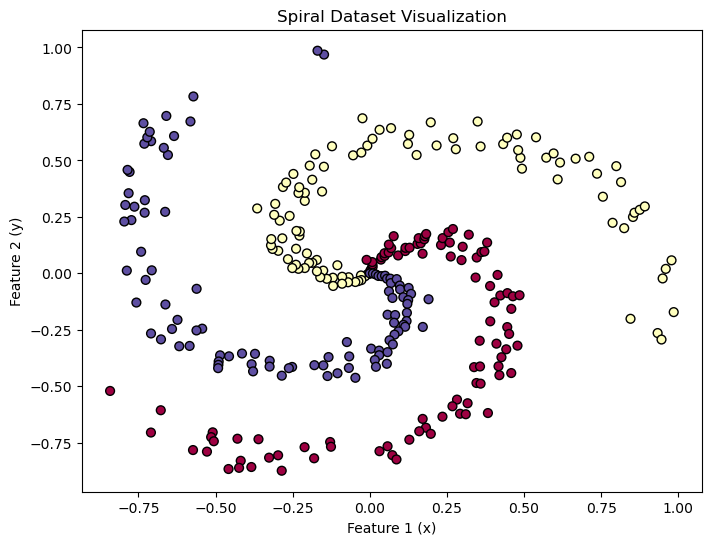

In [71]:
import matplotlib.pyplot as plt

# 1. 產生螺旋資料
X, y = gen_spiral_dataset(N=100, D=2, K=3)

# 2. 建立畫布
plt.figure(figsize=(8, 6))

# 3. 畫出散佈圖 (Scatter Plot)
# X[:, 0] 是橫軸 (x 座標), X[:, 1] 是縱軸 (y 座標)
# c=y 代表根據類別自動上色, s=40 是點的大小, edgecolor='k' 是加上黑色邊框比較好辨識
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolor='k')

# 4. 加上標題與標籤
plt.title("Spiral Dataset Visualization")
plt.xlabel("Feature 1 (x)")
plt.ylabel("Feature 2 (y)")

# 5. 顯示圖表
plt.show()

### 實際的訓練腳本程式

0 iter: 1.0985916677692305
480 iter: 0.7056240023897746
960 iter: 0.6422407772293037
1440 iter: 0.5246104670469967
1920 iter: 0.41864415615146916
2400 iter: 0.37118840940872055
2880 iter: 0.3458348566879158
3360 iter: 0.3295484274744452
3840 iter: 0.31961537369751586
4320 iter: 0.31243947049062526
4800 iter: 0.3062010711375587


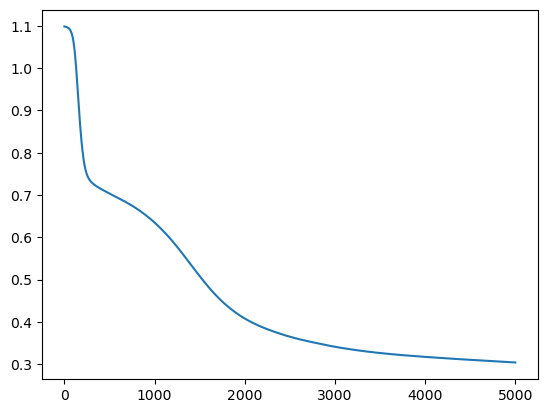

In [ ]:
# 固定隨機種子，確保模型初始化與訓練結果可以被復現
np.random.seed(1)

# 初始化神經網路容器
ann = NeuralNetwork()

# 新增第一層全連接層：輸入維度 2（座標），輸出維度 100，使用高斯分佈初始化
ann.add_layer(Dense(2, 100, ('no', 0.01)))

# 使用 ReLU 激活函數，增加模型的非線性表達能力
ann.add_layer(Relu())

# 新增第二層（輸出層）：輸入 100，輸出 3（代表三個類別）
ann.add_layer(Dense(100, 3, ('no', 0.01)))

# 產生螺旋狀資料集：X 為座標，y 為對應的類別標籤
X, y = gen_spiral_dataset()

# 設定訓練超參數
epochs = 5000         # 總共跑 5000 個訓練週期
batch_size = len(X)   # 這裡使用 Full-batch 訓練（批次大小等於總資料量）
reg = 0.5e-3          # L2 正規化係數（權重衰減）
print_n = 480         # 每隔 480 個迭代印出一次 Loss

# 優化器配置
learning_rate = 1e-1  # 學習率
momentum = 0.5        # 動量（這裡設定較保守，通常預設會用 0.9）
optimizer = SGD(ann.parameters(), learning_rate, momentum)

# 啟動訓練迴圈，使用交叉熵 (Cross Entropy) 作為損失函數
losses = train_nn(ann, X, y, optimizer, cross_entropy_grad_loss, epochs, batch_size, reg, print_n)

# --- 繪圖分析 ---
import matplotlib.pylab as plt
# 在 Jupyter Notebook 中直接顯示圖表
%matplotlib inline
# 繪製 Loss 隨時間下降的曲線圖，用以確認模型是否有正確收斂
plt.plot(losses)

In [87]:
import pandas as pd

data = pd.read_csv('Data/mnist_train.csv')

# 1. One-Hot 轉換
# y = pd.get_dummies(data['label'])
# y = y_onehot_df.values.astype(int) # 此時 y 的 shape 為 (150, 3)
y = data['label'].values.astype(int)
print(y[:5])

# 2. 取得特徵
X = data.iloc[:, 1:].values  # 直接轉成 numpy array 供模型使用
X = X / 255.0

ann = NeuralNetwork()


# 初始化神經網路容器
ann = NeuralNetwork()

# 新增第一層全連接層：輸入維度 2（座標），輸出維度 100，使用高斯分佈初始化
ann.add_layer(Dense(784, 200, ('no', 0.01)))

# 使用 ReLU 激活函數，增加模型的非線性表達能力
ann.add_layer(Relu())

# 新增第二層（輸出層）：輸入 100，輸出 3（代表三個類別）
ann.add_layer(Dense(200, 10, ('no', 0.01)))

# 設定訓練超參數
epochs = 1000          # 總共跑 5000 個訓練週期
batch_size = len(X)   # 這裡使用 Full-batch 訓練（批次大小等於總資料量）
reg = 0.5e-3          # L2 正規化係數（權重衰減）
print_n = 480         # 每隔 480 個迭代印出一次 Loss

# 優化器配置
learning_rate = 0.05  # 學習率
momentum = 0.5        # 動量（這裡設定較保守，通常預設會用 0.9）
optimizer = SGD(ann.parameters(), learning_rate, momentum)

# 啟動訓練迴圈，使用交叉熵 (Cross Entropy) 作為損失函數
losses = train_nn(ann, X, y, optimizer, cross_entropy_grad_loss, epochs, batch_size, reg, print_n)

# --- 繪圖分析 ---
import matplotlib.pylab as plt
# 在 Jupyter Notebook 中直接顯示圖表
%matplotlib inline
# 繪製 Loss 隨時間下降的曲線圖，用以確認模型是否有正確收斂
plt.plot(losses)

[5 0 4 1 9]
0 iter: 2.310624983369324
480 iter: 0.3674972372067518


KeyboardInterrupt: 

In [88]:
# 訓練完成後，計算模型在訓練集上的準確度（Accuracy）
# nn.predict(X) 會回傳預測類別，並與真實標籤 y 比較取平均值
print(np.mean(ann.predict(X) == y))

0.9216666666666666
